In [1]:
import tensorflow as tf
import PIL
from tensorflow.keras import layers
import time
import numpy as np
import matplotlib.pyplot as plt



In [19]:
(train_images,train_labels),(_,_)= tf.keras.datasets.mnist.load_data()

In [20]:
train_images=train_images.reshape(train_images.shape[0],28,28,1).astype(np.float32)

In [21]:
train_images=(train_images-127.5)/127.5

In [22]:
# create the dataset
BUFFER_SIZE = 60000
BATCH_SIZE = 32
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(BATCH_SIZE)

In [23]:
# create the generator

def gen_model():
  model=tf.keras.Sequential()
  model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Reshape((7,7,256)))

  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1), padding='same',use_bias=False))
  assert model.output_shape==(None,7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5,5),strides=(2,2),padding='same',use_bias=False))
  assert model.output_shape==(None,14,14,64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))
  assert model.output_shape==(None,28,28,1)

  return model

In [24]:
generator=gen_model()
generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_6 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 128)        

In [25]:
# create an image with the new generator
noise=tf.random.normal([1,100])
generated_images= generator(noise,training=False)

generated_images.shape

TensorShape([1, 28, 28, 1])

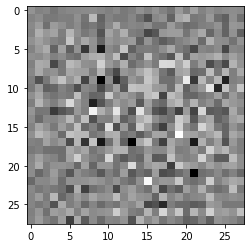

In [26]:
plt.imshow(generated_images[0,:,:,0],cmap='gray')

In [27]:
# discriminator creation
def disc_model():

  model=tf.keras.Sequential()
  model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1,activation='sigmoid'))

  return model

In [28]:
discriminator=disc_model()

In [29]:
# make one decision
decision=discriminator(generated_images)
print(decision)

tf.Tensor([[0.49957055]], shape=(1, 1), dtype=float32)


In [30]:
gan=tf.keras.models.Sequential([generator,discriminator])

In [31]:
# compile
optimizer= tf.keras.optimizers.Adam(1e-4)
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer)
discriminator.trainable=False
gan.compile(loss='binary_crossentropy',optimizer=optimizer)



In [32]:
# training the gan

def train_gan(gan,dataset,batch_size,n_epochs=50):
  generator,discriminator=gan.layers
  for epoch in range(n_epochs):
    print("New epoch started")
    start = time.time()

    for X_batch in dataset:
      # phase 1 training tje discriminator
      noise=tf.random.normal(shape=[batch_size,100])
      generated_images=generator(noise)
      X_fake_and_real=tf.concat([generated_images,X_batch],axis=0)
      y1=tf.constant([[0.]]*batch_size+[[1.]]*batch_size)
      discriminator.trainable=True
      discriminator.train_on_batch(X_fake_and_real,y1)

      # phase 2 training the generator
      noise=tf.random.normal(shape=[batch_size,100])
      y2=tf.constant([[1.]]*batch_size)
      discriminator.trainable=False
      gan.train_on_batch(noise,y2)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


train_gan(gan,train_dataset,BATCH_SIZE)

New epoch started
Time for epoch 1 is 42.11985111236572 sec
New epoch started
Time for epoch 2 is 41.155789375305176 sec
New epoch started
Time for epoch 3 is 40.8705153465271 sec
New epoch started
Time for epoch 4 is 40.875643491744995 sec
New epoch started
Time for epoch 5 is 40.87270498275757 sec
New epoch started
Time for epoch 6 is 41.19143605232239 sec
New epoch started
Time for epoch 7 is 40.7128803730011 sec
New epoch started
Time for epoch 8 is 40.92960333824158 sec
New epoch started
Time for epoch 9 is 40.91702747344971 sec
New epoch started
Time for epoch 10 is 40.85818576812744 sec
New epoch started
Time for epoch 11 is 40.97085666656494 sec
New epoch started
Time for epoch 12 is 40.92260956764221 sec
New epoch started
Time for epoch 13 is 41.29762244224548 sec
New epoch started
Time for epoch 14 is 40.62803626060486 sec
New epoch started
Time for epoch 15 is 40.78602123260498 sec
New epoch started
Time for epoch 16 is 40.8514199256897 sec
New epoch started
Time for epoch 1

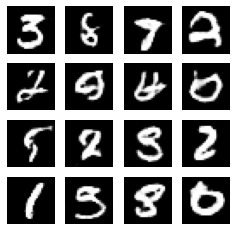

In [33]:
seed = tf.random.normal([16, 100])
predictions =generator(seed, training=False)

fig = plt.figure(figsize=(4,4))

for i in range(predictions.shape[0]):
  plt.subplot(4, 4, i+1)
  plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')